In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [2]:
words = open('../makemore/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
vocab = sorted(list(set(''.join(words))))

stoi = {ch:i+1 for i,ch in enumerate(vocab)}
stoi['.'] = 0

itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(itos)

In [4]:
n = int(len(words) * 0.9)
train_words = words[:n]
val_words = words[n:]

In [23]:
batch_size = 4
n_embd = 8
hidden_dim = 32

In [24]:
def get_batch(split, bs = batch_size):
    inp_seq, out_seq = [], [] # list of sequence of chars in input and output (shifted by 1)
    data = train_words if split == 'train' else val_words
    ix = torch.randint(len(data)-1, (batch_size,))
    batch = [data[i] for i in ix]
    for word in batch:
        chs = word + '.'
        inp, out = [], []
        inp = [stoi[ch1] for ch1,_ in zip(chs, chs[1:])]
        out = [stoi[ch2] for _,ch2 in zip(chs, chs[1:])]

        inp_seq.append(torch.tensor(inp))
        out_seq.append(torch.tensor(out))
    inp_seq_padded = pad_sequence(inp_seq, batch_first=True, padding_value=0)
    out_seq_padded = pad_sequence(out_seq, batch_first=True, padding_value=-1)
    return inp_seq_padded, out_seq_padded

In [25]:
xb, yb = get_batch('train')
# type(xb), type(yb)
xb, yb

(tensor([[ 1, 20,  8,  5, 14,  1,  0,  0],
         [ 2, 18, 25, 14, 19, 12,  5,  5],
         [15, 18, 12,  9,  0,  0,  0,  0],
         [13,  1, 24,  9, 13, 15,  0,  0]]),
 tensor([[20,  8,  5, 14,  1,  0, -1, -1],
         [18, 25, 14, 19, 12,  5,  5,  0],
         [18, 12,  9,  0, -1, -1, -1, -1],
         [ 1, 24,  9, 13, 15,  0, -1, -1]]))

# RNN

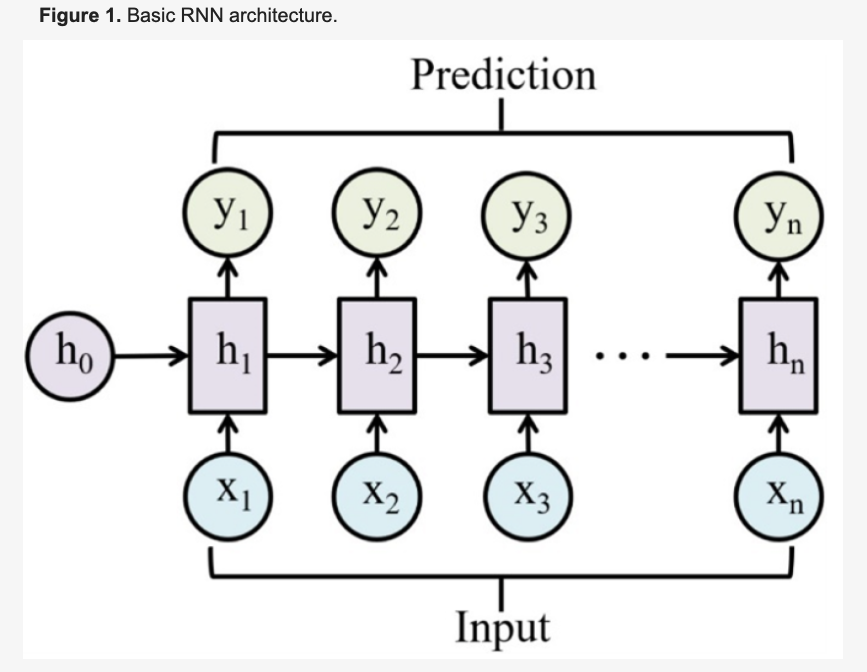

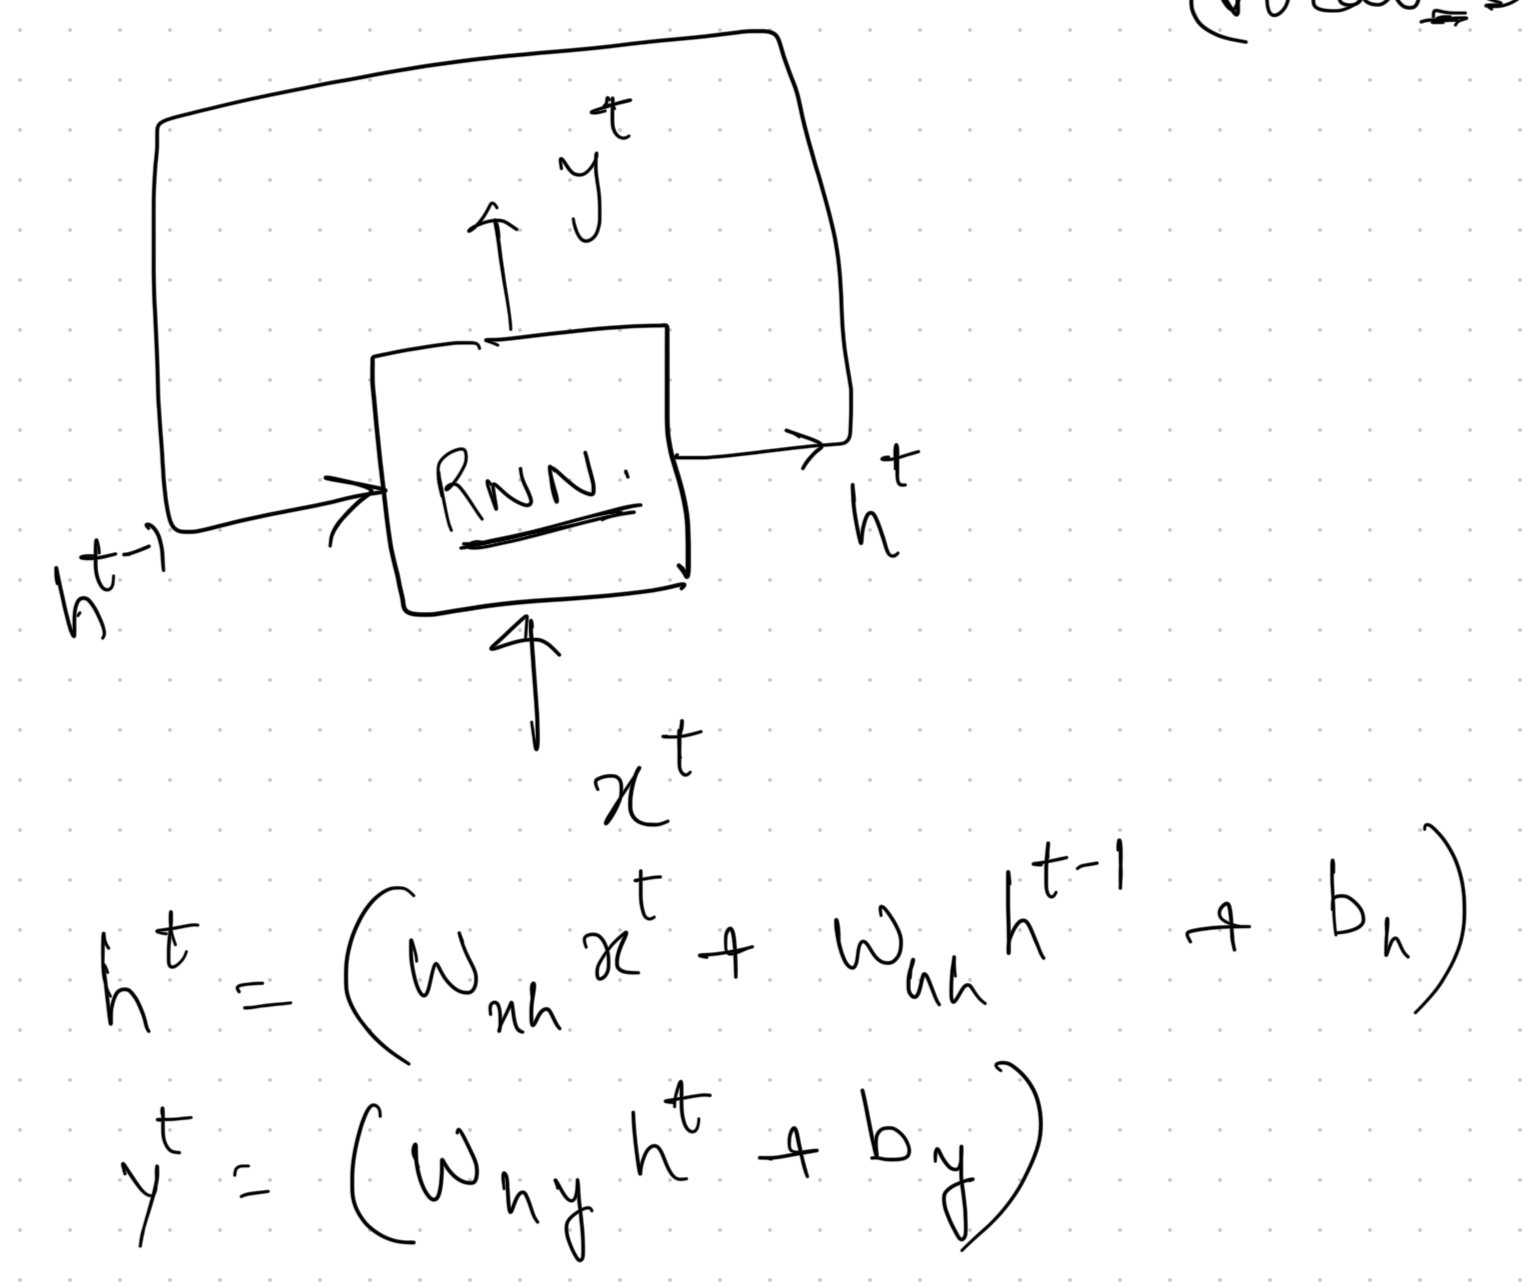

In [105]:
embedding = torch.randn(vocab_size, n_embd) * 0.1
wxh       = torch.randn(n_embd,     hidden_dim) * 0.01
whh       = torch.randn(hidden_dim, hidden_dim) * 0.01
bh        = torch.zeros(hidden_dim)

why       = torch.randn(hidden_dim, vocab_size) * 0.01
by        = torch.zeros(vocab_size)

parameters = [embedding, wxh, whh, bh, why, by]
for p in parameters:
    p.requires_grad = True

In [115]:
max_iters = 2000

for iter in range(max_iters):
    xb, yb = get_batch('train')
    B,T = xb.shape

    # forward pass
    h = torch.zeros(B, hidden_dim)
    logits = []

    x_emb = embedding[xb] # (b,t,n_embd)
    for t in range(T):
        xt = x_emb[:, t, :] # (b,n_embd)
        h  = torch.tanh(xt @ wxh + h @ whh + bh) # (b, hidden_dim)
        yt = h @ why + by                        # (b, vocab_size)
        logits.append(yt)
    # logits # list of T - (b,vocab_size)
    logits = torch.stack(logits, dim=1) # (b,t,vocab_size)

    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1), ignore_index=-1)
    if iter % 100 == 0:
        print(f'{loss.item():.6f}')

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1
    for p in parameters:
        p.data += -(lr * p.grad)

3.295853
2.950211
2.931527
2.776585
2.502740
2.751397
2.372198
2.487826
2.648241
2.442707
2.528796
2.739935
2.346883
2.759680
2.155844
2.508067
2.347218
2.367220
2.296894
2.061975


In [116]:
# generate
for _ in range(5):
    idx = torch.zeros(1,1, dtype=torch.long)
    h = torch.zeros(1, hidden_dim)
    # emb = emb_layer[idx]
    # print(f'emb shape: {emb.shape}')
    count = 0
    while True:
        # print(f'entering the loop for {count + 1}th time')
        emb = embedding[idx[:, -1]] # index last idx from the concatenated version
        h = torch.tanh(emb @ wxh + h @ whh + bh)
        yt = h @ why + by
        # print(f'yt shape: {yt.shape}')
        probs = F.softmax(yt, dim=-1)
        # print(f'shape of probs: {probs.shape}')
        next_idx = torch.multinomial(probs, num_samples=1).item()
        # print(next_idx)
        idx = torch.cat([idx, torch.tensor([[next_idx]])], dim=1)
        if next_idx == 0:
            break
    print(''.join([itos[i.item()] for i in idx[0][1:]]))

ebynw.
ara.
ahidt.
lauiexee.
onirna.
